# Operations with matrix product operators

## Create the MPO we want

In [1]:
import numpy as np
import sympy as sp
from scipy.special import jn
from scipy.linalg import expm, logm
import qutip as qt
import matplotlib.pyplot as plt
from matplotlib import cbook
import psutil
import time

In [2]:
# Pauli Z matrix
sigma_z = np.array([[1.0+0*1j, 0], [0, -1]])

# Identity matrix
I = np.eye(2)

def create_H0_mpo(N, g):
    """
    Creates the MPO for H0 = sum_i g_i sigma_i^z.

    Args:
        N (int): Number of qubits.
        g: Coefficients of g.

    Returns:
        list of np.ndarray: MPO tensors for H0.
    """
    
    mpo = []
    for i in range(N):

        if i == 0:
            # First tensor
            tensor = np.zeros((1, 2, 2, 2), dtype=np.complex128)  # Bond dimension r=2
            tensor[0,0, :, :] = I
            tensor[0,1, :, :] = g * sigma_z
        elif i == N - 1:
            # Last tensor
            tensor = np.zeros((2, 1, 2, 2), dtype=np.complex128)  # Bond dimension r=2
            tensor[0,0, :, :] = g * sigma_z
            tensor[1,0, :, :] = I
        else:
            # Middle tensors
            tensor = np.zeros((2, 2, 2, 2), dtype=np.complex128)  # Bond dimension r=2
            tensor[0,0, :, :] = I
            tensor[0,1, :, :] = g * sigma_z
            tensor[1,1, :, :] = I
        mpo.append(tensor)
        
    return mpo

In [3]:
# Pauli X matrix
sigma_x = np.array([[0, 1.0], [1.0, 0]])

def create_Hc_mpo(N):
    """
    Creates the MPO for Hc = sum_i sigma_i^x.

    Args:
        N (int): Number of qubits.

    Returns:
        list of np.ndarray: MPO tensors for Hc.
    """
    
    mpo = []
    for i in range(N):

        if i == 0:
            # First tensor
            tensor = np.zeros((1, 2, 2, 2), dtype=np.complex128)  # Bond dimension r=2
            tensor[0,0, :, :] = I
            tensor[0,1, :, :] = sigma_x
        elif i == N - 1:
            # Last tensor
            tensor = np.zeros((2, 1, 2, 2), dtype=np.complex128)  # Bond dimension r=2
            tensor[0,0, :, :] = sigma_x
            tensor[1,0, :, :] = I
        else:
            # Middle tensors
            tensor = np.zeros((2, 2, 2, 2), dtype=np.complex128)  # Bond dimension r=2
            tensor[0,0, :, :] = I
            tensor[0,1, :, :] = sigma_x
            tensor[1,1, :, :] = I
        mpo.append(tensor)
        
    return mpo

In [4]:
def create_I_mpo(N):

    mpo = []
    for i in range(N):
        tensor = np.zeros((1, 1, 2, 2), dtype=np.complex128)  # Bond dimension r=1
        tensor[0,0, :, :] = I
        mpo.append(tensor)

    return mpo
        

## Define the functions to operate (sum, product)

In [5]:
def add(mpo1,mpo2):

    assert len(mpo1) == len(mpo2)

    new_mpo = []

    ## First we add the empty first boundary to the new list of core tensors
    new_mpo.append(np.zeros((1,mpo1[0].shape[1]+mpo2[0].shape[1],2,2), dtype=np.complex128))

    ## Add the rectangular tensors in the center
    if len(mpo1)>2:
        for i in range(1,len(mpo1)-1):
            new_mpo.append(np.zeros((mpo1[i].shape[0]+mpo2[i].shape[0],mpo1[i].shape[1]+mpo2[i].shape[1],2,2), dtype=np.complex128))

    ## Add the last ending boundary of the list of tensors
    new_mpo.append(np.zeros((mpo1[len(mpo1)-1].shape[0]+mpo2[len(mpo2)-1].shape[0],1,2,2), dtype=np.complex128))

    ## Compute the tensors for the boundaries
    for j in range(mpo1[0].shape[1]):
        new_mpo[0][0,j,:,:] = mpo1[0][0,j,:,:]
    for k in range(mpo2[0].shape[1]):
        new_mpo[0][0,mpo1[0].shape[1]+k,:,:] = mpo2[0][0,k,:,:]

    for j in range(mpo1[len(mpo1)-1].shape[0]):
        new_mpo[len(mpo1)-1][j,0,:,:] = mpo1[len(mpo1)-1][j,0,:,:]
    for k in range(mpo2[len(mpo2)-1].shape[0]):
        new_mpo[len(mpo2)-1][mpo1[len(mpo1)-1].shape[0]+k,0,:,:] = mpo2[len(mpo2)-1][k,0,:,:]

    ## Now the tensors in the middle
    if len(mpo1)>2:
        for i in range(1,len(mpo1)-1):
            for j in range(mpo1[i].shape[0]):
                for k in range(mpo1[i].shape[1]):
                    new_mpo[i][j,k,:,:] = mpo1[i][j,k,:,:]
    
            for j in range(mpo2[i].shape[0]):
                    for k in range(mpo2[i].shape[1]):
                        new_mpo[i][mpo1[i].shape[0]+j,mpo1[i].shape[1]+k,:,:] = mpo2[i][j,k,:,:]
    
    return new_mpo

In [6]:
def prod_scalar(mpo, c):
    new_mpo = [np.copy(tensor) for tensor in mpo]  # Make a deep copy
    for i in range(new_mpo[0].shape[0]):
        for j in range(new_mpo[0].shape[1]):
            for k in range(new_mpo[0].shape[2]):
                for l in range(new_mpo[0].shape[3]):
                    new_mpo[0][i, j, k, l] *= c
    return new_mpo

In [7]:
def prod(mpo1,mpo2):
    
    assert len(mpo1) == len(mpo2)

    new_mpo = []

    ## First we add the empty first boundary to the new list of core tensors
    new_mpo.append(np.zeros((1,mpo1[0].shape[1]*mpo2[0].shape[1],2,2), dtype=np.complex128))

    ## Add the rectangular tensors in the center
    if len(mpo1)>2:
        for i in range(1,len(mpo1)-1):
            new_mpo.append(np.zeros((mpo1[i].shape[0]*mpo2[i].shape[0],mpo1[i].shape[1]*mpo2[i].shape[1],2,2), dtype=np.complex128))

    ## Add the last ending boundary of the list of tensors
    new_mpo.append(np.zeros((mpo1[len(mpo1)-1].shape[0]*mpo2[len(mpo2)-1].shape[0],1,2,2), dtype=np.complex128))

    ## Compute the tensors for the boundaries
    for j in range(mpo1[0].shape[1]):
        for k in range(mpo2[0].shape[1]):
            new_mpo[0][0,k+j*(mpo2[0].shape[1]),:,:] = np.outer(mpo1[0][0,j,:,0],mpo2[0][0,k,0,:])+np.outer(mpo1[0][0,j,:,1],mpo2[0][0,k,1,:])

    for j in range(mpo1[len(mpo1)-1].shape[0]):
        for k in range(mpo2[len(mpo2)-1].shape[0]):
            new_mpo[len(mpo1)-1][k+j*(mpo2[len(mpo2)-1].shape[0]),0,:,:] = np.outer(mpo1[len(mpo1)-1][j,0,:,0],mpo2[len(mpo2)-1][k,0,0,:])+np.outer(mpo1[len(mpo1)-1][j,0,:,1],mpo2[len(mpo2)-1][k,0,1,:])


    ## Now we compute the values of the intermediate tensor cores
    if len(mpo1)>2:
        ## For each core tensor
        for i in range(1,len(mpo1)-1):
            ## Take each element of the first tensor
            for j in range(mpo1[i].shape[0]):
                for k in range(mpo1[i].shape[1]):

                    ## Compute with all the elements of the equivalent tensor in second mpo
                    for s in range(mpo2[i].shape[0]):
                        for t in range(mpo2[i].shape[1]):
                            new_mpo[i][s+j*(mpo2[i].shape[1]),t+k*(mpo2[i].shape[1]),:,:] = np.outer(mpo1[i][j,k,:,0],mpo2[i][s,t,0,:])+np.outer(mpo1[i][j,k,:,1],mpo2[i][s,t,1,:])

    return new_mpo

## From MPO to full matrix

In [8]:
def contract(mpo):
    ## Create list for recursive multiplication of matrices, step by step
    mpo_contracted = []
    ## We define the first one as it's fixed
    mpo_contracted.append(mpo[0])
    for n in range(len(mpo)-1):
        ## For the first compression starting left to right we set an empty compressed tensor
        mpo_contracted.append(np.zeros((mpo[n].shape[0],mpo[n+1].shape[1],2**(n+2),2**(n+2)), dtype=np.complex128))
            
        for i in range(mpo[n+1].shape[1]):
            ## Now go over every element and take matrix multiplication with kronecker product
            mpo_comp = 0
            for j in range(mpo[n].shape[1]):
                mpo_comp += np.kron((mpo_contracted[n])[0,j,:,:],(mpo[n+1])[j,i,:,:])

                ## Add in the list to continue with the next compression
                (mpo_contracted[n+1])[0,i] = mpo_comp
                
    return mpo_contracted[len(mpo)-1][0][0]

In [9]:
def commutator(mpo1,mpo2):
    return add(prod(mpo1,mpo2),prod_scalar(prod(mpo2,mpo1),-1))

In [10]:
def commute(M1,M2):
    return (M1 @ M2) - (M2 @ M1) 

## Bond reduction of the tensors

In [11]:
def reduce(mpo, bond_dimension):
    """
    Reduce the bond dimension of an MPO using SVD truncation.
    
    Args:
        mpo (list of np.ndarray): Input MPO tensors.
        bond_dimension (int): Target bond dimension after reduction.
        
    Returns:
        list of np.ndarray: Reduced MPO tensors.
    """
    new_mpo = []
    carry_over = None
    
    for i, tensor in enumerate(mpo):
        if carry_over is not None:
            # Merge the carry_over with current tensor
            # carry_over has shape (new_dleft, dright, phys_out)
            # tensor has shape (dleft, dright, phys_in, phys_out)
            # We need to contract carry_over with the left bond of the tensor
            tensor = np.einsum('mjk,ijkl->imkl', carry_over, tensor)
            
        # Original dimensions
        dleft, dright, phys_in, phys_out = tensor.shape
        
        # Combine left and physical dimensions
        matrix = tensor.transpose(0, 2, 1, 3).reshape(dleft * phys_in, dright * phys_out)
        
        # Perform SVD
        U, S, Vh = np.linalg.svd(matrix, full_matrices=False)
        
        # Truncate
        trunc = min(bond_dimension, len(S))
        U = U[:, :trunc]
        S = S[:trunc]
        Vh = Vh[:trunc, :]
        
        # Update bond dimension
        new_dright = trunc
        
        # Reshape U back to tensor
        new_tensor = U.reshape(dleft, phys_in, new_dright, -1).transpose(0, 2, 1, 3)
        new_mpo.append(new_tensor)
        
        # Prepare carry_over for next tensor (S * Vh)
        carry_over = np.diag(S) @ Vh
        carry_over = carry_over.reshape(new_dright, dright, phys_out)
    
    # Handle the last carry_over
    if carry_over is not None:
        # For the last tensor, reshape carry_over to match the expected shape
        # The last tensor should have shape (new_dright, 1, phys_out, 1)
        # Ensure the size of carry_over matches the target shape
        expected_size = new_dright * 1 * phys_out * 1
        if carry_over.size != expected_size:
            raise ValueError(f"Size mismatch: carry_over has size {carry_over.size}, but expected size is {expected_size}.")
        last_tensor = carry_over.reshape(new_dright, 1, phys_out, 1)
        new_mpo.append(last_tensor)
    
    return new_mpo

## Magnus and Chebyshev approximations for evolution

In [12]:
def Magnus_mpo(mpo_H0,mpo_Hc,u,T):

    """
   First step to solve the time-dependent Schrödinger equation via Magnus expansion.

    Parameters:
    - mpo_H0: numpy array, static Hamiltonian as mpo
    - mpo_Hc: numpy array, control Hamiltonian as mpo
    - u: function u(t) defining time dependence
    - T: float, total evolution time

    Returns:
    - M: Magnus series
    """

    ## Magnus series (order 2)
    t1, t2, t3 = sp.symbols('t1 t2 t3')

    a = -1j*sp.integrate(1,(t1,0,T))
    b = -1j*sp.integrate(u(t1), (t1, 0, T)) 

    M1 = add(prod_scalar(mpo_H0,a),prod_scalar(mpo_Hc,b))

    c = -1/2 * sp.integrate(sp.integrate(u(t2)-u(t1),(t2,0,t1)),(t1,0,T))

    M2 = prod_scalar(commutator(mpo_H0,mpo_Hc),c)

    d = 1j/6 * sp.integrate(sp.integrate(sp.integrate(u(t3)-2*u(t2)+u(t1),(t3,0,t2)),(t2,0,t1)),(t1,0,T))
    e = 1j/6 * sp.integrate(sp.integrate(sp.integrate(2*u(t1)*u(t3)-u(t1)*u(t2)-u(t2)*u(t3),(t3,0,t2)),(t2,0,t1)),(t1,0,T))

    M3 = add(prod_scalar(commutator(mpo_H0,commutator(mpo_H0,mpo_Hc)),d),prod_scalar(commutator(commutator(mpo_Hc,mpo_H0),mpo_Hc),e))
    
    M = add(M1,M2)

    return M

In [13]:
def Magnus(H0,Hc,u,T):

    """
   First step to solve the time-dependent Schrödinger equation via Magnus expansion.

    Parameters:
    - mpo_H0: numpy array, static Hamiltonian as mpo
    - mpo_Hc: numpy array, control Hamiltonian as mpo
    - u: function u(t) defining time dependence
    - T: float, total evolution time

    Returns:
    - M: Magnus series
    """
    def commute(M1,M2):
        return (M1 @ M2) - (M2 @ M1)

    ## Magnus series (order 2)
    t1, t2, t3 = sp.symbols('t1 t2 t3')

    a = -1j*sp.integrate(1,(t1,0,T))
    b = -1j*sp.integrate(u(t1), (t1, 0, T)) 

    M1 = (a*H0) + (b*Hc)

    c = -1/2 * sp.integrate(sp.integrate(u(t2)-u(t1),(t2,0,t1)),(t1,0,T))

    M2 = c*commute(H0,Hc)

    d = 1j/6 * sp.integrate(sp.integrate(sp.integrate(u(t3)-2*u(t2)+u(t1),(t3,0,t2)),(t2,0,t1)),(t1,0,T))
    e = 1j/6 * sp.integrate(sp.integrate(sp.integrate(2*u(t1)*u(t3)-u(t1)*u(t2)-u(t2)*u(t3),(t3,0,t2)),(t2,0,t1)),(t1,0,T))

    M3 = d*(commute(H0,commute(H0,Hc))) + e*(commute(commute(Hc,H0),Hc))
    
    M = M1 + M2

    return M

In [14]:
def Chebyshev_mpo(mpo,N):
    """ 
    Approximation of exponentiation of Magnus series to find the solution to the Schrödinger equation
    """

    ##Bessel function constants
    
    a = jn(0,1)+2*jn(2,1)
    b = 2*jn(1,1)
    c = 4*jn(2,1)

    C1 = prod_scalar(create_I_mpo(N),a)
    C2 = prod_scalar(mpo,b)
    C3 = prod_scalar(prod(mpo,mpo),c)

    C = add(add(C1,C2),C3)

    
    return C

In [15]:
def Chebyshev(M,N):
    """ 
    Approximation of exponentiation of Magnus series to find the solution to the Schrödinger equation
    """

    ##Bessel function constants
    
    a = jn(0,1)+2*jn(2,1)
    b = 2*jn(1,1)
    c = 4*jn(2,1)

    C1 = a*np.eye(M.shape[0])
    C2 = b*M
    C3 = (c*M) @ M

    C = C1+C2

    
    return C

## Exact evolution

In [16]:
import qutip.settings
from scipy.sparse import csr_matrix
qutip.settings.auto_tidyup = False


def get_unitary(H0, Hc, u, T, timesteps=1000):
    """
    Solves the time-dependent Schrödinger equation and returns the unitary evolution matrix.

    Parameters:
    - H0: numpy array, static Hamiltonian
    - Hc: numpy array, control Hamiltonian
    - u: function u(t) defining time dependence
    - T: float, total evolution time
    - timesteps: int, number of time steps for integration

    Returns:
    - U_T: numpy array, final unitary matrix at time T
    """

    # Convert matrices to Qobj
    H0_q = qt.Qobj(H0, dims=[[H0.shape[0]], [H0.shape[1]]], isherm=True)
    Hc_q = qt.Qobj(Hc,  dims=[[H0.shape[0]], [H0.shape[1]]], isherm=True)
    
    # Time-dependent Hamiltonian
    H = [H0_q, [Hc_q, u]]

    # Initial state (identity operator for unitary evolution)
    identity = qt.qdiags([1] * H0.shape[0], 0)
    psi0 = identity

    # Time array
    tlist = np.linspace(0, T, timesteps)
    
    options = {"nsteps": 10000, "method": "bdf"}
    result = qt.sesolve(H, psi0, tlist, options=options)

    # Extract final unitary matrix
    U_T = result.states[-1].full()

    return U_T

In [17]:
def err_fidelity(U,V):

    ## Computes the fidelity error: 1-fidelity

    d = U.shape[0]  # Dimension of the unitary matrices
    fidelity = (np.abs(np.trace(np.conj(U.T) @ V)) / d) ** 2
    return np.abs(1 - fidelity)

In [18]:
def compare_time_mem(N,g,T,u):

    ## Compare the time and memory it takes to compute with mpo and without

    process = psutil.Process()

    mem_before = process.memory_info().rss / (1024**2)
    start_mpo = time.time()
    mpo1 = prod_scalar(create_H0_mpo(N,g),1/2**N)
    mpo2 = prod_scalar(create_Hc_mpo(N),1/2**N)
    Mag = Magnus_mpo(mpo1,mpo2,u, T)
    U_computed = Chebyshev_mpo(Mag,N)
    time_mpo = time.time() - start_mpo
    mem_after = process.memory_info().rss / (1024**2)
    mem_mpo = mem_after - mem_before

    mem_before = process.memory_info().rss / (1024**2)
    start_exact = time.time()
    H0 = contract(mpo1)
    Hc = contract(mpo2)
    U_exact = get_unitary(H0,Hc,u, T)
    time_exact = time.time() - start_exact
    mem_after = process.memory_info().rss / (1024**2)
    mem_exact = mem_after - mem_before

    err = err_fidelity(U_exact,contract(U_computed))


    return time_exact, time_mpo, mem_exact, mem_mpo, err

In [19]:
def compare(N,g,T):

    ## Compare (error) the exact solution to the MPO solution with Magnus and M+C
    
    mpo1 = prod_scalar(create_H0_mpo(N,g),1/2**N)
    mpo2 = prod_scalar(create_Hc_mpo(N),1/2**N)
    H0 = contract(mpo1)
    Hc = contract(mpo2)

    ## Define the control function
    def u(t):
        return 1-t+t**2

    U_exact = get_unitary(H0,Hc,u, T)
    Mag = Magnus_mpo(mpo1,mpo2,u, T)
    U_computed = Chebyshev_mpo(Mag,N)

    Err = err_fidelity(U_exact,contract(U_computed))

    return Err

In [20]:
def compare_mpo(N,g,T,u):
    process = psutil.Process()

    mem_before = process.memory_info().rss / (1024**2)
    start_mpo = time.time()
    
    mpo1 = prod_scalar(create_H0_mpo(N,g),1/2**N)
    mpo2 = prod_scalar(create_Hc_mpo(N),1/2**N)

    Mag = Magnus_mpo(mpo1,mpo2,u, T)
    U_computed = Chebyshev_mpo(Mag,N)

    time_mpo = time.time() - start_mpo
    mem_after = process.memory_info().rss / (1024**2)
    mem_mpo = mem_after - mem_before

    return time_mpo, mem_mpo

## MPO data

In [21]:
N = 30
g = 1
T = 0.5
reps = 3

def u(t):
    return 1-t+t**2  # Example function, replace with your actual one

In [22]:
time_mpo = []
memory_mpo = []

for j in range(1,reps+1):
    print(j)
    list_time = []
    list_mem = []
    for i in range(2,N+1):
        time1, mem1 = compare_mpo(i,g,T,u)
    
        list_time.append(time1)
        list_mem.append(mem1)
    time_mpo.append(list_time)
    memory_mpo.append(list_mem)

1
2
3


In [23]:
# Compute element-wise mean
data_matrix_time_mpo = np.array(time_mpo)
data_matrix_memory_mpo = np.array(memory_mpo)

mean_values_time_mpo = np.mean(data_matrix_time_mpo, axis=0)
mean_values_memory_mpo = np.mean(data_matrix_memory_mpo, axis=0)# Mean along columns

std_values_time_mpo = np.std(data_matrix_time_mpo, axis=0)
std_values_memory_mpo = np.std(data_matrix_memory_mpo, axis=0)

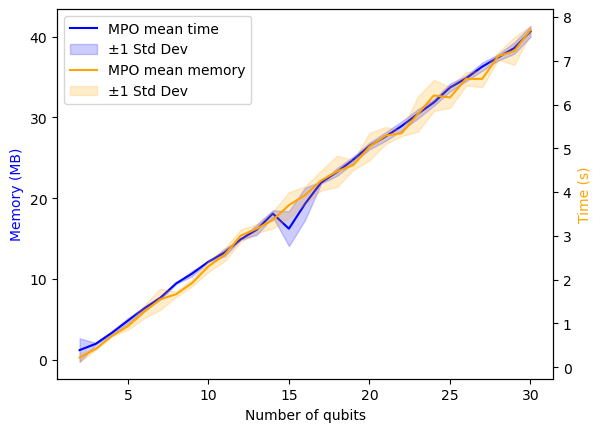

In [24]:
fig, ax1 = plt.subplots()

# Create secondary y-axis
ax2 = ax1.twinx()
#for j in range(reps):
    # Plot memory usage
    #ax1.plot(range(2, N+1), memory_mpo[j],linestyle="--", linewidth=1, alpha=0.2, color="blue")  # Solid blue for MPO
    
    # Plot time usage
    #ax2.plot(range(2, N+1), time_mpo[j],linestyle="--", linewidth=1, alpha=0.2, color="orange")  # Solid blue for MPO
    
# Plot time usage
ax1.plot(range(2, N+1), mean_values_memory_mpo, 'b-', label="MPO mean time")  # Solid blue for MPO
ax2.plot(range(2, N+1), mean_values_time_mpo,'orange', linestyle='-', label="MPO mean memory")  # Solid blue for MPO

ax1.fill_between(range(2, N+1),mean_values_memory_mpo - std_values_memory_mpo, mean_values_memory_mpo + std_values_memory_mpo, color="blue", alpha=0.2, label="±1 Std Dev")  # Shaded std dev region
ax2.fill_between(range(2, N+1),mean_values_time_mpo - std_values_time_mpo, mean_values_time_mpo + std_values_time_mpo, color="orange", alpha=0.2, label="±1 Std Dev")  # Shaded std dev region


# Labels and colors
ax1.set_xlabel('Number of qubits')
ax1.set_ylabel('Memory (MB)', color='blue')  # Blue for memory axis
ax2.set_ylabel('Time (s)', color='orange')  # Green for time axis

# Legends (need to combine both axes legends)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

# Save and show plot
plt.savefig("Time_memory_mpo (2,2)")
plt.show()

## Plots

### Compare MPO evolution to exact

In [27]:
N1 = 8
g = 1
T = 0.5

def u(t):
    return 1-t+t**2  # Example function, replace with your actual one

In [28]:
times_dense = []
errs = []
memories_dense = []

for j in range(1,reps+1):
    print(j)
    list_time = []
    list_mem = []
    for i in range(2,N1+1):
        time1, _, mem1, _, _ = compare_time_mem(i,g,T,u)
    
        # Store results
        list_time.append(time1)
        list_mem.append(mem1)
    times_dense.append(list_time)
    memories_dense.append(list_mem)

1
2
3


In [29]:
memories_dense

[[0.0859375,
  0.203125,
  0.05859375,
  14.796875,
  61.26953125,
  251.1171875,
  1017.3671875],
 [0.11328125,
  -1013.23046875,
  3.78125,
  11.44140625,
  61.65625,
  252.83203125,
  700.13671875],
 [0.0234375,
  0.7890625,
  2.59765625,
  15.07421875,
  61.65625,
  175.38671875,
  1017.01953125]]

In [30]:
# Compute element-wise mean
data_matrix_times_dense = np.array(times_dense)
data_matrix_memories_dense = np.array(memories_dense)

mean_values_times_dense = np.mean(data_matrix_times_dense, axis=0)
mean_values_memories_dense = np.mean(data_matrix_memories_dense, axis=0)# Mean along columns

std_values_times_dense = np.std(data_matrix_times_dense, axis=0)
std_values_memories_dense = np.std(data_matrix_memories_dense, axis=0)

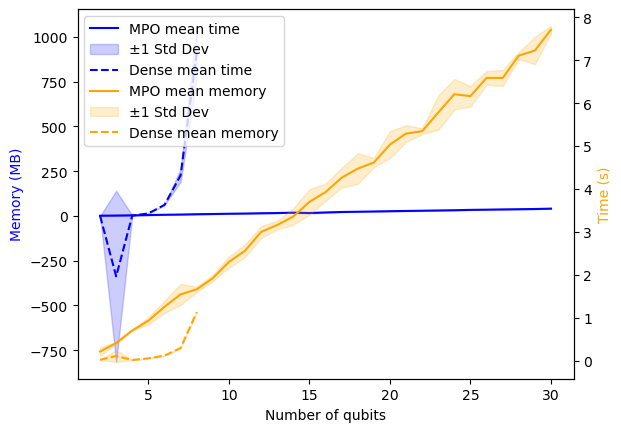

In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax1 = plt.subplots()

# Create secondary y-axis
ax2 = ax1.twinx()
#for j in range(reps):
    # Plot memory usage
    #ax1.plot(range(2, N+1), memory_mpo[j],linestyle="--", linewidth=1, alpha=0.2, color="blue")  # Solid blue for MPO
    
    # Plot time usage
    #ax2.plot(range(2, N+1), time_mpo[j],linestyle="--", linewidth=1, alpha=0.2, color="orange")  # Solid blue for MPO
    
# Plot time usage
ax1.plot(range(2, N+1), mean_values_memory_mpo, 'b-', label="MPO mean time")  # Solid blue for MPO
ax2.plot(range(2, N+1), mean_values_time_mpo,'orange', linestyle='-', label="MPO mean memory")  # Solid blue for MPO

ax1.fill_between(range(2, N+1),mean_values_memory_mpo - std_values_memory_mpo, mean_values_memory_mpo + std_values_memory_mpo, color="blue", alpha=0.2, label="±1 Std Dev")  # Shaded std dev region
ax2.fill_between(range(2, N+1),mean_values_time_mpo - std_values_time_mpo, mean_values_time_mpo + std_values_time_mpo, color="orange", alpha=0.2, label="±1 Std Dev")  # Shaded std dev region


# Plot time usage
ax1.plot(range(2, N1+1), mean_values_memories_dense, 'b--', label="Dense mean time")  # Solid blue for MPO
ax2.plot(range(2, N1+1), mean_values_times_dense,'orange', linestyle='--', label="Dense mean memory")  # Solid blue for MPO

ax1.fill_between(range(2, N1+1),mean_values_memories_dense - std_values_memories_dense, mean_values_memories_dense + std_values_memories_dense, color="blue", alpha=0.2)  # Shaded std dev region
ax2.fill_between(range(2, N1+1),mean_values_times_dense - std_values_times_dense, mean_values_times_dense + std_values_times_dense, color="orange", alpha=0.2)  # Shaded std dev region

# Labels and colors
ax1.set_xlabel('Number of qubits')
ax1.set_ylabel('Memory (MB)', color='blue')  # Blue for memory axis
ax2.set_ylabel('Time (s)', color='orange')  # Green for time axis

# Legends (need to combine both axes legends)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

# Save and show plot
plt.savefig("Time_memory_full (2,2)")
plt.show()

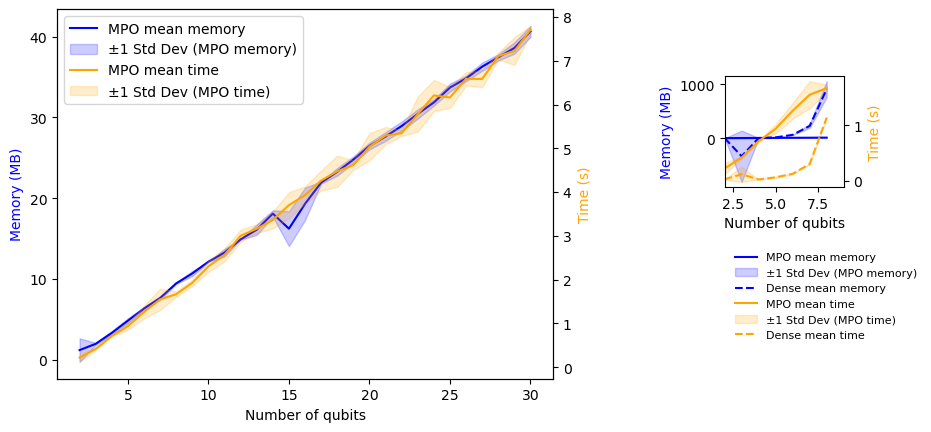

In [32]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import ConnectionPatch
import numpy as np

fig, ax1 = plt.subplots()

# Create secondary y-axis
ax2 = ax1.twinx()

# === Main Plot (Only MPO Data) ===
# Plot MPO mean and std dev for memory and time
ax1.plot(range(2, N+1), mean_values_memory_mpo, 'b-', label="MPO mean memory")  # Solid blue for MPO memory
ax2.plot(range(2, N+1), mean_values_time_mpo, 'orange', linestyle='-', label="MPO mean time")  # Solid orange for MPO time
ax1.fill_between(range(2, N+1), mean_values_memory_mpo - std_values_memory_mpo, mean_values_memory_mpo + std_values_memory_mpo, color="blue", alpha=0.2, label="±1 Std Dev (MPO memory)")
ax2.fill_between(range(2, N+1), mean_values_time_mpo - std_values_time_mpo, mean_values_time_mpo + std_values_time_mpo, color="orange", alpha=0.2, label="±1 Std Dev (MPO time)")

# Labels and colors for main plot
ax1.set_xlabel('Number of qubits')
ax1.set_ylabel('Memory (MB)', color='blue')  # Blue for memory axis
ax2.set_ylabel('Time (s)', color='orange')  # Orange for time axis

# Legends for main plot (only MPO data)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

# === Inset Plot (Both MPO and Dense Data) ===
# Create inset axes outside the main plot
ax_inset1 = inset_axes(ax1, width="30%", height="30%", loc="lower right", bbox_to_anchor=(0.8, 0.5, 0.8, 1), bbox_transform=ax1.transAxes)

# Create secondary y-axis in the inset
ax_inset2 = ax_inset1.twinx()

# Plot MPO mean and std dev for memory and time in inset
ax_inset1.plot(range(2, N1+1), mean_values_memory_mpo[:N1-1], 'b-', label="MPO mean memory")  # Solid blue for MPO memory
ax_inset2.plot(range(2, N1+1), mean_values_time_mpo[:N1-1], 'orange', linestyle='-', label="MPO mean time")  # Solid orange for MPO time
ax_inset1.fill_between(range(2, N1+1), mean_values_memory_mpo[:N1-1] - std_values_memory_mpo[:N1-1], mean_values_memory_mpo[:N1-1] + std_values_memory_mpo[:N1-1], color="blue", alpha=0.2, label="±1 Std Dev (MPO memory)")
ax_inset2.fill_between(range(2, N1+1), mean_values_time_mpo[:N1-1] - std_values_time_mpo[:N1-1], mean_values_time_mpo[:N1-1] + std_values_time_mpo[:N1-1], color="orange", alpha=0.2, label="±1 Std Dev (MPO time)")

# Plot dense mean and std dev for memory and time in inset
ax_inset1.plot(range(2, N1+1), mean_values_memories_dense, 'b--', label="Dense mean memory")  # Dashed blue for dense memory
ax_inset2.plot(range(2, N1+1), mean_values_times_dense, 'orange', linestyle='--', label="Dense mean time")  # Dashed orange for dense time
ax_inset1.fill_between(range(2, N1+1), mean_values_memories_dense - std_values_memories_dense, mean_values_memories_dense + std_values_memories_dense, color="blue", alpha=0.2)
ax_inset2.fill_between(range(2, N1+1), mean_values_times_dense - std_values_times_dense, mean_values_times_dense + std_values_times_dense, color="orange", alpha=0.2)

# Set labels and limits for inset
ax_inset1.set_xlabel('Number of qubits')
ax_inset1.set_ylabel('Memory (MB)', color='blue')
ax_inset2.set_ylabel('Time (s)', color='orange')
ax_inset1.set_xlim(2, N1+1)

# Move the inset legend outside the inset plot
lines_inset1, labels_inset1 = ax_inset1.get_legend_handles_labels()
lines_inset2, labels_inset2 = ax_inset2.get_legend_handles_labels()

# Combine legend handles and labels, removing duplicates
from collections import OrderedDict
handles = lines_inset1 + lines_inset2
labels = labels_inset1 + labels_inset2
by_label = OrderedDict(zip(labels, handles))  # Remove duplicates
ax_inset1.legend(by_label.values(), by_label.keys(), loc="upper left", bbox_to_anchor=(0, -0.5), fontsize=8, frameon=False)


# Save and show plot
plt.savefig("Time_memory_mpo_with_inset.png", dpi=300, bbox_inches="tight")
plt.show()